# ¿Qué tan importante son las fuentes de ingreso para un aplicante de préstamos en línea?

In [1]:
import pandas as pd
import numpy  as np
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from scipy import interp
from statsmodels.formula.api import ols
import seaborn as sns
from matplotlib.widgets import Slider, Button, RadioButtons
from scipy.optimize import fsolve

#get_ipython().magic(u'matplotlib inline')

## Introducción (5 mts)

**Contexto de negocios.** Una compañía P2P tiene un sistema online que acepta o rechaza préstamos en línea. Se rechazan todos aquellos que no posean una fuente verificable de ingresos

**Problema.** ¿Debería de verificarse la fuente de ingresos antes de aprobar un préstamo?

**Contexto analítico.** fuente: [LendingClub Statistics](https://www.lendingclub.com/info/download-data.action) préstamos de 2007 - 2012. usaremos **regresión logística**, para responder la pregunta.

## Exploración de los datos (45 mts)

In [2]:
df = pd.read_csv("Lending_club_cleaned_2.csv")
df.loan_status = df.loan_status.astype(pd.api.types.CategoricalDtype(categories=["Charged Off", "Fully Paid"]))
df.verification_status = df.verification_status.astype(pd.api.types.CategoricalDtype(categories=['Not Verified', 'Source Verified', 'Verified']))
df.emp_length = df.emp_length.astype(pd.api.types.CategoricalDtype(categories=["< 1 year", "1 year", "2 years", "3 years", "4 years", \
                                                             "5 years", "6 years", "7 years", "8 years", "9 years", \
                                                             "10+ years"]))
df.home_ownership = df.home_ownership.astype(pd.api.types.CategoricalDtype(categories=["RENT", "MORTGAGE","OWN","OTHER"]))
df.term = df.term.astype(pd.api.types.CategoricalDtype(categories=[" 36 months", " 60 months"]))
df.grade = df.grade.astype(pd.api.types.CategoricalDtype(categories=["A","B","C","D","E","F","G"]))
df.int_rate = df.int_rate.str.rstrip("%").astype("float")

In [3]:
df.shape

(38705, 10)

In [4]:
df.head(10)

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
0,Fully Paid,24000.0,Verified,10+ years,RENT,10.65,5000,credit_card,36 months,B
1,Charged Off,30000.0,Source Verified,< 1 year,RENT,15.27,2500,car,60 months,C
2,Fully Paid,12252.0,Not Verified,10+ years,RENT,15.96,2400,small_business,36 months,C
3,Fully Paid,49200.0,Source Verified,10+ years,RENT,13.49,10000,other,36 months,C
4,Fully Paid,80000.0,Source Verified,1 year,RENT,12.69,3000,other,60 months,B
5,Fully Paid,36000.0,Source Verified,3 years,RENT,7.90,5000,wedding,36 months,A
6,Fully Paid,47004.0,Not Verified,8 years,RENT,15.96,7000,debt_consolidation,60 months,C
7,Fully Paid,48000.0,Source Verified,9 years,RENT,18.64,3000,car,36 months,E
8,Charged Off,40000.0,Source Verified,4 years,OWN,21.28,5600,small_business,60 months,F
9,Charged Off,15000.0,Verified,< 1 year,RENT,12.69,5375,other,60 months,B


38706 observaciones. Cada una corresponde a un crédito aprobado. La primera columna indica si fue pagado (Fully paid) o no (Charged Off). Las otras 9 columnas son las siguientes:

|      annual_inc     |                                                 The self-reported annual income provided by the borrower during registration.                                                |
|:-------------------:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
| verification_status |                                          Indicates if income was verified by LC, not verified, or if the income source was verified                                          |
|      emp_length     |                       Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.                      |
|    home_ownership   |             The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER            |
|       int_rate      |                                                                           Interest Rate on the loan                                                                          |
|      loan_amnt      | The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value. |
|       purpose       |                                                           A category provided by the borrower for the loan request.                                                          |
|         term        |                                             The number of payments on the loan. Values are in months and can be either 36 or 60.                                             |
|        grade        |                                                                            LC assigned loan grade                                                                            |

### Relación entre `loan_status` otras variables (25 mts)

Consideremos las variables continuas primero

### Ejercicio 1: (5 mts)

Haga 3 diagramas de caja comparando `annual_inc`, `int_rate` y `loan_amnt` contra `loan_status`

**Respuesta.** Al final de la función boxplot, utilice .set_yscale('log')

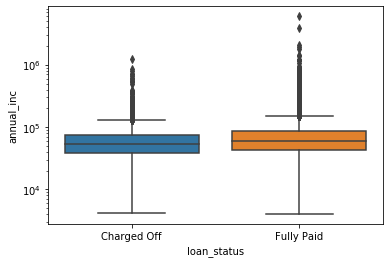

In [4]:
sns.boxplot(y="annual_inc", x="loan_status", data = df).set_yscale('log');

Aquellos que pagan tienen ligeramente más ingresos en promedio

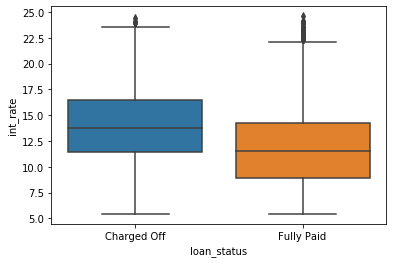

In [5]:
sns.boxplot(y="int_rate", x ='loan_status', data = df);

La diferencia es más drástica teniendo en cuenta la tasa de interés.

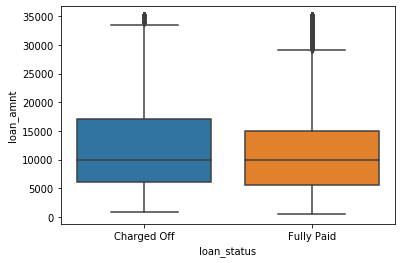

In [6]:
sns.boxplot(y="loan_amnt", x ='loan_status', data = df)

Los usuarios que pagan la deuda parecen contar con montos menores

We learned in previous hypothesis testing cases that we can use contingency tables to examine the relationship between two discrete variables. A chi-square test can be performed based on the contigency table to verify if the observed relationship is statistically significant. Let's examine all discrete variables in our dataset.

### Ejercicio 2: (10 mts)

La siguiente función contruye una tabla de contigencia entre una variable `var` y `loan_status`, incluyendo la proporción de usuarios que pagaron la deuda. Esta tabla sirve para comparar la relación con las variables discretas.

**Respuesta.**

In [8]:
def get_ct(df, var):
    ct_res = pd.crosstab(df[var], df['loan_status'], margins=True)
    ct_res["Fully Paid(%)"] = round( ct_res["Fully Paid"]/ct_res["All"]*100, 2)
    return ct_res.drop(columns="All")

In [9]:
get_ct( df, 'verification_status')

loan_status,Charged Off,Fully Paid,Fully Paid(%)
verification_status,,,
Not Verified,2050,14449,87.58
Source Verified,1413,8406,85.61
Verified,1977,10410,84.04
All,5440,33265,85.94


In [10]:
get_ct( df, 'emp_length' )

loan_status,Charged Off,Fully Paid,Fully Paid(%)
emp_length,,,
< 1 year,641,3947,86.03
1 year,460,2787,85.83
2 years,571,3823,87.01
3 years,558,3540,86.38
4 years,466,2978,86.47
5 years,459,2826,86.03
6 years,309,1922,86.15
7 years,263,1512,85.18
8 years,206,1279,86.13


In [11]:
get_ct( df, 'home_ownership' )

loan_status,Charged Off,Fully Paid,Fully Paid(%)
home_ownership,,,
RENT,2752,15755,85.13
MORTGAGE,2268,14987,86.86
OWN,402,2443,85.87
OTHER,18,80,81.63
All,5440,33265,85.94


In [12]:
get_ct( df, 'purpose' )

loan_status,Charged Off,Fully Paid,Fully Paid(%)
purpose,,,
car,155,1344,89.66
credit_card,516,4491,89.69
debt_consolidation,2703,15572,85.21
educational,52,265,83.60
home_improvement,333,2554,88.47
house,59,310,84.01
major_purchase,211,1905,90.03
medical,101,569,84.93
moving,84,475,84.97


In [13]:
get_ct( df, 'term' )

loan_status,Charged Off,Fully Paid,Fully Paid(%)
term,,,
36 months,3073,25211,89.14
60 months,2367,8054,77.29
All,5440,33265,85.94


In [14]:
get_ct( df, 'grade' )

loan_status,Charged Off,Fully Paid,Fully Paid(%)
grade,,,
A,558,9136,94.24
B,1362,10335,88.36
C,1296,6642,83.67
D,1097,4116,78.96
E,710,2101,74.74
F,317,718,69.37
G,100,217,68.45
All,5440,33265,85.94


### Ejercicio 3: (5 mts)

Usar el test de chi cuadrado para ver si las asociaciones son estadísticamente significativas

**Respuesta.** Para cada tabla de contingencia:

In [15]:
chi2, p, dof, ex = chi2_contingency(pd.crosstab(df['verification_status'], df['loan_status']))
print('verification_status: p-value of chisquare test =', p)

verification_status: p-value of chisquare test = 6.884998281535999e-17


In [18]:
chi2, p, dof, ex = chi2_contingency(pd.crosstab(df['emp_length'], df['loan_status']))
print('emp_length: p-value of chisquare test =', p)

emp_length: p-value of chisquare test = 0.06419956286286349


In [19]:
chi2, p, dof, ex = chi2_contingency(pd.crosstab(df['home_ownership'], df['loan_status']))
print('home_ownership: p-value of chisquare test =', p)

home_ownership: p-value of chisquare test = 3.094754275730736e-05


In [20]:
chi2, p, dof, ex = chi2_contingency(pd.crosstab(df['purpose'], df['loan_status']))
print('purpose: p-value of chisquare test =', p)

purpose: p-value of chisquare test = 6.53325963877868e-71


In [21]:
chi2, p, dof, ex = chi2_contingency(pd.crosstab(df['term'], df['loan_status']))
print('term: p-value of chisquare test =', p)

term: p-value of chisquare test = 2.7851291583847273e-194


In [22]:
chi2, p, dof, ex = chi2_contingency(pd.crosstab(df['grade'], df['loan_status']))
print('grade: p-value of chisquare test =', p)

grade: p-value of chisquare test = 0.0


Casi todas son significativas salvo `emp_length`, y `verification_status` tiene un resultado contraintuitivo

### Tablas estratificadas de `verification_status` vs. `loan_status` (15 mts)

In [16]:
def get_ct_stra(stra_var):
    ct_stra = pd.crosstab(index=[stra_var,df.verification_status], columns = df.loan_status, margins = True)
    ct_stra["Fully Paid (%)"] = round(ct_stra["Fully Paid"]/ct_stra["All"]*100,2)
    return ct_stra.drop(columns="All").drop("All", level=0)

In [17]:
get_ct_stra(df.home_ownership)

loan_status                         Charged Off  Fully Paid  Fully Paid (%)
home_ownership verification_status                                         
RENT           Not Verified                1072        7133           86.93
               Source Verified              815        4332           84.17
               Verified                     865        4290           83.22
MORTGAGE       Not Verified                 798        6064           88.37
               Source Verified              487        3443           87.61
               Verified                     983        5480           84.79
OWN            Not Verified                 170        1210           87.68
               Source Verified              110         622           84.97
               Verified                     122         611           83.36
OTHER          Not Verified                  10          42           80.77
               Source Verified                1           9           90.00
               Verified                       7          29           80.56

In [18]:
get_ct_stra(df.term)

loan_status                     Charged Off  Fully Paid  Fully Paid (%)
term       verification_status                                         
 36 months Not Verified                1580       12574           88.84
           Source Verified              688        6132           89.91
           Verified                     805        6505           88.99
 60 months Not Verified                 470        1875           79.96
           Source Verified              725        2274           75.83
           Verified                    1172        3905           76.92

La diferencia en los pagos verificados y no-verificados podría darse por el efecto del término de los préstamos, pero no por el hecho de tener o no vivienda propia. Usuarios con ingreso no verificado parecen ser más propensos a pagar la deuda.

In [19]:
pd.crosstab(df['term'], df['verification_status'])

verification_status,Not Verified,Source Verified,Verified
term,,,
36 months,14154,6820,7310
60 months,2345,2999,5077


## Regresión logística: entendiendo el modelo lineal a salidas binarias (20 mts)

Del test chi cuadrado, sabemos que la variable verification status está marginalmente asociada la probabilidad de pagar. El modelo de regresión logística  es una modificación del modelo estándar lineal que maneja problemas de clasificación (paga la deuda o no). Los Odds de un evento es la tasa de probabilidad exitosa sobre el fracaso. Los Odds se pagar una deuda se definen así:

$$
\text{Odds}(\text{Full payment}) = \frac{p}{1-p}.
$$

Donde $p$ es la probabilidad de pagar.

La función lineal es la siguiente:

\begin{equation}
\log(\text{Odds}) = \beta_0 + \beta_1*\text{verification_status}. \tag{1}
\end{equation}

Codificamos diferentes niveles de `verification_status` usando enteros: "Not Verified" como 0, "Source Verified" como 1 y "Verified" como 2; si $\beta_1$ es positivo, entonces hay una tendencia creciente en la probabilidad de pagar en tanto que la verificación se vuelve más confiable. Si $\beta_1$ es negativo, sucede lo contrario.

### Interpretación numérica (5 mts)

$p$ - valor de cada coeficiente. Es el resultado del siguiente test de hipótesis:

$$
H_0: \beta = 0~vs.~ H_A: \beta \neq 0.
$$

El test determina si diferencias en la probabildiad de pagar están asociadas a cambios de la variable correspondiente.

### Geometric interpretation of logistic regression (5 mts)

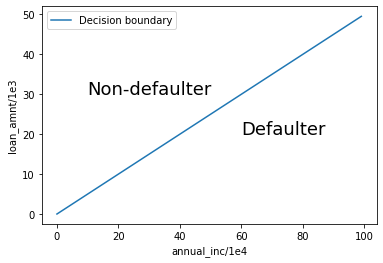

In [20]:
x = np.arange(0,100,1)
y = x/2
plt.plot(x, y, label = "Decision boundary");
plt.xlabel("annual_inc/1e4");
plt.ylabel("loan_amnt/1e3");
plt.text(10, 30, "Non-defaulter", fontsize = 18)
plt.text(60, 20, "Defaulter", fontsize = 18)
plt.legend();

La forma del umbral de decisión puede ser también una curva

### Visualizar el umbral de decisión (5 mts)

Considere el siguiente modelo para $p$:

$$
\log(p/(1-p)) = \beta_0 + \beta_1*loan\_amnt+\beta_2*annual\_inc+\beta_3*loan\_amnt^2.
$$

El umbral de decisión con valor $p = 0.5$ es

$$
\beta_0 + \beta_1*loan\_amnt+\beta_2*annual\_inc+\beta_3*loan\_amnt^2 = 0.
$$


In [21]:
%matplotlib widget
import ipywidgets as widgets
from ipywidgets import interact

idx_plot = np.random.choice(df.shape[0], size=500, replace = False)
plt_data = df.iloc[idx_plot]

fig, ax = plt.subplots()
#plt.subplots_adjust(left=0.25, bottom=0.35)
plt.scatter(plt_data[plt_data.loan_status=="Fully Paid"].annual_inc/10000, \
            plt_data[plt_data.loan_status=="Fully Paid"].loan_amnt/1000, \
            c = 'blue', label = 'Fully paid')
plt.scatter(plt_data[plt_data.loan_status=="Charged Off"].annual_inc/10000, \
            plt_data[plt_data.loan_status=="Charged Off"].loan_amnt/1000, \
            c = 'red', label = 'Charged off')
plt.xlim(0,40);
plt.legend();

#plot boundary
beta0 = 1
beta1 = -1
beta2 = 1
beta3 = -1

x_plt = np.arange(0,40,1)
y_plt = (-beta0 - beta1*x_plt - beta3*x_plt**2)/(beta2)
plt.xlabel("annual_inc/1e4")
plt.ylabel("loan_amnt/1e3")
l, = plt.plot(x_plt, y_plt, lw = 2, color="k", label = "Current Decision boundary")
plt.ylim(0,60);
plt.legend();

def update(beta0=1, beta1=-1, beta2=1, beta3=-1):
    y_plt = (-beta0 - beta1*x_plt - beta3*x_plt**2)/(beta2)
    l.set_ydata(y_plt);
    fig.canvas.draw_idle();

interact(update, beta0 = widgets.FloatSlider(value=beta0,min=-10,max=10,step=0.5),\
         beta1 = widgets.FloatSlider(value=beta1,min=-10,max=10,step=0.5),
         beta2 = widgets.FloatSlider(value=beta2,min=0.5,max=10,step=0.5),
         beta3 = widgets.FloatSlider(value=beta3,min=-10,max=0,step=0.5));

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=1.0, description='beta0', max=10.0, min=-10.0, step=0.5), FloatSlider(…

In [31]:
%matplotlib inline

## Ajuste del modelo logístico (25 mts)

Utilizando el paquete `statmodels`

In [22]:
# Codificar las variables discretas
df_log1 = pd.DataFrame(columns=['verification_status','loan_status'])
df_log1['verification_status'] = df.verification_status.cat.codes
df_log1['loan_status'] = df.loan_status.cat.codes
df_log1['Intercept'] = 1

logit = sm.Logit(df_log1['loan_status'], df_log1[['Intercept','verification_status']])
logit_res = logit.fit()
print( logit_res.summary() )

Optimization terminated successfully.
         Current function value: 0.405007
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                38705
Model:                          Logit   Df Residuals:                    38703
Method:                           MLE   Df Model:                            1
Date:                Mon, 17 Feb 2020   Pseudo R-squ.:                0.002350
Time:                        21:06:06   Log-Likelihood:                -15676.
converged:                       True   LL-Null:                       -15713.
Covariance Type:            nonrobust   LLR p-value:                 8.419e-18
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.9469      0.022     88.290      0.000       1.904       1.990
ve

Cuando `verfication_status` se incrementa en una undiad, los Odds se pagar se disminuyen en 14%. Dado que el $p$-valor es menor a 0.05, la 
tendencia que observamos en la tabla de contigencia no es producto del azar.



El `Pseudo R-squ.` es una métrica similar al `R-Cuadrado.`, cuya interpretación es más ambigua. De todas formas se buscan valores moderados de este.

### Evaluar la codificación de `verification_status` (5 mts)

El código anterior asume que los log-odds $p/(1-p)$ entre personas con niveles consecutivos de `verification_status` es el mismo. Esto es un supuesto fuerte. Ahora usaremos variables dummy para los diferentes niveles. Not Verified será el nivel de referencia.

In [23]:
vs_dummy = pd.get_dummies(df.verification_status, drop_first=True)
vs_dummy.head()

,Source Verified,Verified
0,0,1
1,1,0
2,0,0
3,1,0
4,1,0


In [24]:
#vs_dummy = pd.get_dummies(df.verification_status, drop_first=True )
df_log1 = pd.concat([df_log1,vs_dummy], axis = 1)

logit_dummy = sm.Logit(df_log1['loan_status'], df_log1[['Intercept','Source Verified','Verified']])
logit_dummy_res = logit_dummy.fit()
print( logit_dummy_res.summary() )

Optimization terminated successfully.
         Current function value: 0.405001
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                38705
Model:                          Logit   Df Residuals:                    38702
Method:                           MLE   Df Model:                            2
Date:                Mon, 17 Feb 2020   Pseudo R-squ.:                0.002366
Time:                        21:11:16   Log-Likelihood:                -15676.
converged:                       True   LL-Null:                       -15713.
Covariance Type:            nonrobust   LLR p-value:                 7.140e-17
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.9528      0.024     82.741      0.000       1.907       1.999
Source Verifie

Los resultados confirman que la probabilidad de pagar decrece a medida que la información del ingreso se vuelve más confiable.

### Evaluando el modelo (15 mts)

El $R^2$ no puede traducirse para evaluar el modelo.

Podemos utilizar la curva ROC:  **receiver operating characteristic (ROC) curve**.

Tasa de verdaderos positivos: `true positive rate` (TPR) y tasa de verdaderos negativos: `true negative rate` (TNR). In our context, TPR es la proporción de gente que pagó la deuda y fue correctamente clasificada, TNR es la proporción de morosos que fueron identificados como tal.

En ocasiones es difícil hacer que ambas medidas sean altas; en este caso es más importante la tasa de verdaderos negativos, puesto que es preferible prestarle a morosos que no prestarle a buenos candidatos.

El área bajo la curva se calcula como el **AUC**, donde cantidades cercanas a la unidad, indican una predicción buena. La curva ROC para una selección al azar es una línea diagonal. 

In [25]:
predict_p = logit_res.predict(df_log1[['Intercept','verification_status']])
predict_dummy_p = logit_dummy_res.predict(df_log1[['Intercept','Source Verified','Verified']])
roc_p = roc_curve(df_log1["loan_status"], predict_p)
roc_dummy_p = roc_curve(df_log1["loan_status"], predict_dummy_p)
auc_p = auc( roc_p[0], roc_p[1] )
auc_dummy_p = auc( roc_dummy_p[0], roc_dummy_p[1] )

plt.figure()
lw = 2
plt.plot(roc_p[0], roc_p[1], color='darkorange',
         lw=lw, label='ROC curve for coding scheme 1 (AUC = %0.2f)' % auc_p)
plt.plot(roc_dummy_p[0], roc_dummy_p[1], color='darkgreen',
         lw=lw, label='ROC curve for coding scheme 2 (AUC = %0.2f)' % auc_dummy_p)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc="lower right")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Dado que la curva ROC tiene un AUC cerca al 0.5, se confirma que `verification_status` por sí sola no es buen predictor más allá de elegir al azar. Esto también confirma que no hay diferencia entre las codificaciones anteriormente usadas, así que se mantendrá la primera por simplicidad.

### Exercise 7: (5 mts)

En estadística, ¿son preferibles los modelos simples o complejos?

**Respuesta.**

## Agregando variables adicionales al modelo (20 mts)

La presencia de variables adicionales podría arrojar resultados más contundentes:

In [27]:
# Preprocesar las variables, estandarizar y dummy
df_log2 = pd.concat([(df.loan_amnt - df.loan_amnt.mean())/df.loan_amnt.std(),\
                     (df.int_rate - df.int_rate.mean())/df.int_rate.std(),\
                     (df.annual_inc - df.annual_inc.mean())/df.annual_inc.std(),\
                     pd.get_dummies(df.home_ownership, prefix="home", drop_first=True), \
                     pd.get_dummies(df.purpose, prefix="purpose", drop_first=True), \
                     pd.get_dummies(df.grade, prefix="grade",drop_first=True)], axis=1)
df_log2["verification_status"] = df.verification_status.cat.codes
df_log2["emp_length"] = df.emp_length.cat.codes
df_log2["term"] = df.term.cat.codes
df_log2["Intercept"] = 1

In [28]:
logit_full1 = sm.Logit(df.loan_status.cat.codes, df_log2)
logit_full1_res = logit_full1.fit()
print(logit_full1_res.summary())

Optimization terminated successfully.
         Current function value: 0.378075
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                38705
Model:                          Logit   Df Residuals:                    38676
Method:                           MLE   Df Model:                           28
Date:                Mon, 17 Feb 2020   Pseudo R-squ.:                 0.06869
Time:                        21:18:21   Log-Likelihood:                -14633.
converged:                       True   LL-Null:                       -15713.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
loan_amnt                     -0.0075      0.019     -0.389      0.697      

### Ejercicio 8: (5 mts)

¿Es correcta la siguiente afirmación?

No hay evidencia que soporte la relación entre la probabilidad de pagar y la variable `verification_status`

**Respuesta**
Correcta, su $p$-valor es mucho mayor al 0.05 de significancia.

## ¿Es necesario incluir? `verification_status`? (10 mts)

`verification_status` No importa para la predicción.

### Exercise 10: (5 mts)

¿Cuál de las siguientes opciones es correcta sobre la variable `verification_status`?

A. Como el $p$-valor es grande, podemos quitar la variable del modelo de clasificación.

B. Aunque el $p$-valor sea grande, su coeficiente de regresión es distinto de cero, por lo que deberíamos considerarla.

C. Debería de hacerse una evaluación final para comparar las predicciones del modelo con y sin `verification_status` antes de decidir removerla.

D. Ninguna de las anteriores.

**Respuesta.** C. Nunca se aconseja tomar decisiones basadas únicamente en el $p$-valor

Comparemos la precisión en la predicción usando la curva ROC:

In [29]:
predict_withvs = logit_full1_res.predict(df_log2)
logit_full_novs = sm.Logit(df.loan_status.cat.codes, df_log2.loc[:, df_log2.columns != 'verification_status'])
predict_novs = logit_full_novs.fit(disp=0).predict(df_log2.loc[:, df_log2.columns != 'verification_status'])

roc_vs = roc_curve(df.loan_status.cat.codes, predict_withvs)
roc_novs = roc_curve(df.loan_status.cat.codes, predict_novs)
auc_vs = auc( roc_vs[0], roc_vs[1] )
auc_novs = auc( roc_novs[0], roc_novs[1])

plt.figure()
lw = 2
plt.plot(roc_vs[0], roc_vs[1], color='darkorange',
         lw=lw, label='With verification_status (AUC = %0.2f)' % auc_vs)
plt.plot(roc_novs[0], roc_novs[1], color='darkgreen',
         lw=lw, label='Without verification_status (AUC = %0.2f)' % auc_novs)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc="lower right")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Exercise 11: (5 mts)

¿Qué es puede concluir del proceso de validación después de observar los AUC de ambos modelos?

**Respuesta.** Los AUC no cambian, y como se prefiere un modelo tan sencillo como sea posible se decide no incluir la variable.

## Conclusiones (5 mts)

Al principio encontramos un resultado contraintuitivo por la falta de variables explicativas. Luego de hacer el fit del modelo completo encontramos la verdadera tendencia.

En resumen, el proceso de verificación de ingresos es irrelevante y puede ser potencialmente removido para simplificar el sistema de préstamos.

## Aprendizajes (5 mts)

Regresión logística similar a lineal, pero para tareas de clasificación. Curva ROC para comparar modelos.